In [1]:
""" https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
https://user.ceng.metu.edu.tr/~emre/resources/courses/AdvancedDL_Spring2017/DQN_Muhammed.pdf
https://www.youtube.com/watch?v=NP8pXZdU-5U&t=1s
"""
import matplotlib.pyplot as plt
import torch
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from SnakeEnvironment import *
from Agent import *
import collections
import random
from itertools import count
#from Util import HyperParameters, TrainingData, save_session
import torchvision.transforms.functional as fn


pygame 2.1.2 (SDL 2.0.18, Python 3.10.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


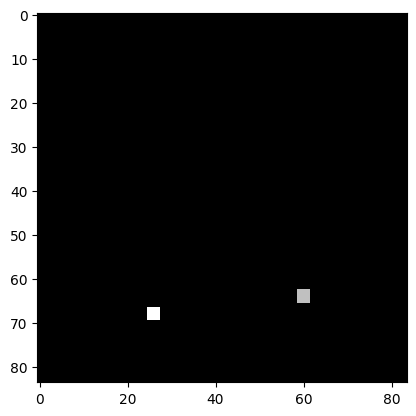

In [2]:
game_env = SnakeEnvironment(seed=5, # Try both constant seed and varying seed for each episode
                            display_gameplay=False)
game_env.initialize_environment()
screen = game_env.get_state()
plt.imshow(screen.resize_(84,84),cmap="gray",vmin=0,vmax=1)


In [7]:
def get_screen(_env: SnakeEnvironment):


game_env.get_state()

tensor([[5., 5., 5., 5., 5., 5., 5.],
        [5., 0., 0., 0., 0., 0., 5.],
        [5., 2., 0., 0., 0., 0., 5.],
        [5., 0., 0., 0., 0., 0., 5.],
        [5., 0., 0., 0., 0., 0., 5.],
        [5., 3., 0., 0., 0., 0., 5.],
        [5., 5., 5., 5., 5., 5., 5.]])

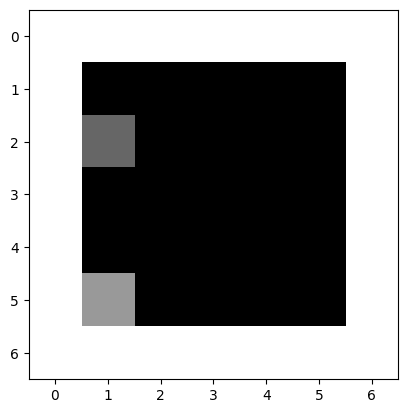

In [8]:
plt.imshow(game_env.get_state(),cmap="gray")

In [9]:
a=3
grid = torch.zeros(size=(a+2,a+2))
grid[0] = grid[a+1] = grid[:,0] = grid[:,a+1] = 1
grid

tensor([[1., 1., 1., 1., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 0., 0., 0., 1.],
        [1., 1., 1., 1., 1.]])

Epsilon projection for final eps = 0.0:


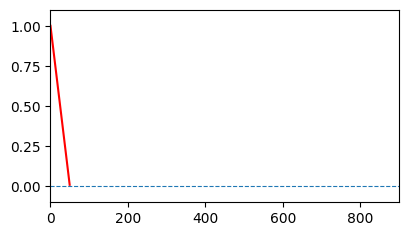

In [7]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 1.0
EPS_END = 0.0
EPS_DECAY = 0.02
TARGET_UPDATE = 10
MY_SEED = 0
LR = 0.0001
MEMORY_SIZE = 1000000

NUM_EPISODES = 900

state_size = 18
nr_actions = 4

agent_007 = Agent(gamma=GAMMA,exploration_rate=EPS_START,lr=LR,
                  input_size=state_size, batch_size=BATCH_SIZE,
                  nr_actions=nr_actions, max_mem_size=MEMORY_SIZE,
                  nr_episodes=NUM_EPISODES, exploration_rate_min=EPS_END,
                  exploration_decay_rate=EPS_DECAY,seed=MY_SEED)

my_params = HyperParameters(batch_size=BATCH_SIZE,gamma=GAMMA,eps_0=EPS_START,
                            eps_min=EPS_END,eps_decay_rate=EPS_DECAY,
                            target_update_freq=TARGET_UPDATE,learning_rate=LR,
                            memory_size=MEMORY_SIZE,n_episodes=NUM_EPISODES)

print(f"Epsilon projection for final eps = {EPS_END}:")
fig, ax = plt.subplots(1,1,figsize=(4.5,2.5))
eps = np.linspace(0.00001,NUM_EPISODES,1000)

#### Different epsilon decay strategies ####
#ys = 1.0 - EPS_DECAY * eps
#ys = agent_007.stretched_exponential_view(eps,NUM_EPISODES,EPS_START,EPS_END)
ys = agent_007.linear_view(eps,EPS_START,EPS_DECAY)
#ys = agent_007.exponential(eps,EPS_START,EPS_END,EPS_DECAY)
#ys = agent_007.oscillator(eps,EPS_START,EPS_END,NUM_EPISODES,A = 3.5,B=20)
#ys = agent_007.inverse_power(eps,EPS_DECAY,EPS_START,EPS_END)
#ys = agent_007.exponential_ski_hill(eps,EPS_DECAY,EPS_START,EPS_END)
eps, ys = eps[ys >= EPS_END], ys[ys >= EPS_END]
ax.plot(eps, ys,'r-')
ax.set_xlim(0,NUM_EPISODES)
ax.set_ylim(-0.1,1.1)
ax.hlines(EPS_END,0,NUM_EPISODES,lw=0.8,ls='--')
plt.show()

In [8]:
episode_durations = []
episode_rewards = []
episode_scores = []
episode_exploration_rates = []
episode_max_iteration_tokens = []
episode_memory_size = []

In [9]:
t_count = 0
with tqdm(range(NUM_EPISODES)) as progress_bar:
    for i_episode in progress_bar:
        # Initialize the environment and state
        game_env = SnakeEnvironment(seed=MY_SEED + i_episode,  # Try both constant seed and varying seed for each episode
                                    display_gameplay=False)
        game_env.initialize_environment()

        current_game_reward = 0
        current_game_duration = 0

        current_exploration_rate = 0
        current_steps_counter = 0
        game_over = False
        current_state = game_env.get_state()

        #print(current_state)
        for t in count():
            # Select and perform an action according to greedy epsilon strategy
            action = agent_007.choose_action(current_state)

            # Perform action in game environment and observe reward and new state + termination flag.
            reward, game_over, new_observation = game_env.step(action)
            current_game_reward += reward
            reward = torch.tensor([reward])

            # Observe new state
            last_state = current_state
            current_state = new_observation

            # Store the transition in memory
            # print(type(last_state), type(action),type(reward),type(current_state),type(game_over))
            agent_007.store_transition(state=last_state,action=action,
                                       reward=reward,new_state=current_state,
                                       done_flag=game_over)


            # Perform one step of the optimization (on the policy network)
            agent_007.learn(i_episode)
            if game_over:
                break
            current_game_duration += 1

            # Update the target network, copying all weights and biases in DQN from policy to target network
            if t % TARGET_UPDATE == 0:
                agent_007.align_networks()
            t_count+=1

        episode_rewards.append(current_game_reward)
        episode_scores.append(game_env.current_score)
        episode_durations.append(current_game_duration)
        episode_exploration_rates.append(agent_007.exploration_rate)
        episode_max_iteration_tokens.append(game_env.max_iteration_token)
        episode_memory_size.append(t_count)

        progress_bar.set_postfix({"Score": game_env.current_score,
                                  "Duration": current_game_duration,
                                  "Eps":agent_007.exploration_rate})

  0%|          | 1/900 [00:00<00:08, 102.66it/s, Score=0, Duration=5, Eps=1]

head x: 0
head y: 3
head x: 1
head y: 3
head x: 2
head y: 3
head x: 2
head y: 4
head x: 1
head y: 4
head x: 0
head y: 4
head x: -1
head y: 4
head x: 3
head y: 4
head x: 4
head y: 4
head x: 5
head y: 4


IndexError: index 5 is out of bounds for dimension 0 with size 5

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
print("Total games exited due to max iterations reached: ", sum(episode_max_iteration_tokens))
ax[0].plot([i for i in range(len(episode_max_iteration_tokens))], episode_max_iteration_tokens,lw=0.5)
ax[0].set_title("Max Iterations Markers")
ax[0].set_xlabel("Episode")

ax[1].plot([i for i in range(len(episode_memory_size))], episode_memory_size,lw=0.5)
ax[1].set_title("Memory size")
ax[1].set_xlabel("Episode")
ax[1].hlines(MEMORY_SIZE,0,NUM_EPISODES,ls='--')
plt.show()

In [ ]:
fig, ax = plt.subplots(2,2,figsize=(20,10))
ax[0][0].plot([i for i in range(len(episode_scores))], episode_scores,lw=0.5)
ax[0][0].set_title("Game score")
ax[0][0].set_xlabel("Episode")
ax[0][0].set_ylabel("Score")

ax[0][1].plot([i for i in range(len(episode_rewards))], episode_rewards,lw=0.5)
ax[0][1].set_title("Game reward")
ax[0][1].set_xlabel("Episode")
ax[0][1].set_ylabel("Score")


ax[1][0].plot([i for i in range(len(episode_durations))], episode_durations,lw=0.5)
ax[1][0].set_title("Steps survived")
ax[1][0].set_xlabel("Episode")
ax[1][0].set_ylabel("Nr. steps")

ax[1][1].plot([i for i in range(len(episode_exploration_rates))], episode_exploration_rates,lw=0.5)
ax[1][1].set_title("Epsilon")
ax[1][1].set_xlabel("Episode")
ax[1][1].set_ylabel("Epsilon")

plt.show()

In [ ]:
#### Saving current run ####

from os import listdir
from os.path import isfile, join

data = TrainingData(scores=episode_scores,steps=episode_durations,
                    eps=episode_exploration_rates, rewards=episode_rewards)
file_numbers = [int(f[4:-4]) for f in listdir("Data/") if isfile(join("Data/", f))]
already_exists = True
nr = None
while already_exists:
    nr = np.random.randint(0,100000,size=1)[0]
    if nr not in file_numbers:
        already_exists = False
save_session(filename=f'Data/run_{nr}.txt',
             note="Using Linear eps. decay. + distance to apple reward.", params=my_params,agent=agent_007, data=data, env=game_env)

In [ ]:
avg_period = NUM_EPISODES//100
avg_episode_scores, avg_episode_durations, avg_episode_exploration_rates = [], [], []
for period in range(0, len(episode_rewards) // avg_period):
    avg_episode_scores.append(np.mean(episode_scores[avg_period * period : avg_period * (period + 1)]))
    avg_episode_durations.append(np.mean(episode_durations[avg_period * period : avg_period * (period + 1)]))
    avg_episode_exploration_rates.append(np.mean(episode_exploration_rates[avg_period * period : avg_period * (period + 1)]))

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,4))
ax[0].plot([ i for i in range(len(avg_episode_scores))], avg_episode_scores,lw=0.5)
ax[1].plot([ i for i in range(len(avg_episode_durations))], avg_episode_durations,lw=0.5)
ax[2].plot([ i for i in range(len(avg_episode_exploration_rates))], avg_episode_exploration_rates,lw=0.5)
plt.show()

In [ ]:
Play_game = False
if Play_game:
    game_env = SnakeEnvironment(seed=1109,  # Try both constant seed and varying seed for each episode
                                neural_net=agent_007.policy_network,
                                display_gameplay=True,
                                graphics_speed=6)
    game_env.run()



In [ ]:
for t in tqdm(range(0,10000)):
    game_env = SnakeEnvironment(seed=t,  # Try both constant seed and varying seed for each episode
                                neural_net=agent_007.policy_network,
                                display_gameplay=False,
                                graphics_speed=100)
    game_env.run()
    if game_env.current_score > 90:
        print("seed: ", t, "score: ", game_env.current_score)